In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import datetime as dt

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score
from sklearn.preprocessing import StandardScaler, LabelEncoder

import torch
import torchvision
import torch.nn as nn
from torch.nn import functional as F
from torch.utils.tensorboard import SummaryWriter
from torch.utils.data import DataLoader, random_split, TensorDataset

%matplotlib inline

In [2]:
np.random.seed(42)
device = 'cuda:2' if torch.cuda.is_available() else 'cpu'
device

'cuda:2'

## Data visualization

In [15]:
data = pd.read_csv('data.csv',parse_dates = True, index_col=0)
data

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
1996-08-09,14.250000,16.750000,14.250000,16.500000,14.892752,1601500
1996-08-12,16.500000,16.750000,16.375000,16.500000,14.892752,260900
1996-08-13,16.500000,16.750000,16.375000,16.375000,14.779927,162800
1996-08-14,16.375000,16.625000,16.375000,16.375000,14.779927,59500
1996-08-15,16.625000,16.625000,16.375000,16.625000,15.005575,62300
...,...,...,...,...,...,...
2021-04-01,35.270000,36.340000,35.099998,36.139999,36.139999,111400
2021-04-05,36.580002,36.849998,36.200001,36.529999,36.529999,114000
2021-04-06,36.650002,36.930000,36.349998,36.660000,36.660000,66100


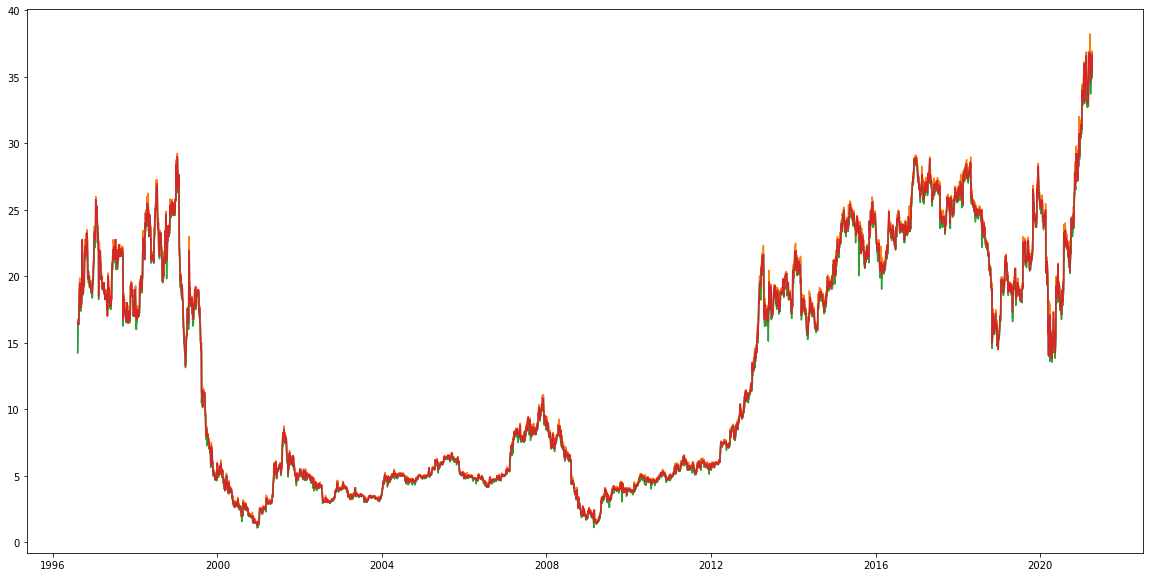

In [4]:
plt.figure(figsize=(20,10))
plt.plot(data['Open'])
plt.plot(data['High'])
plt.plot(data['Low'])
plt.plot(data['Close'])

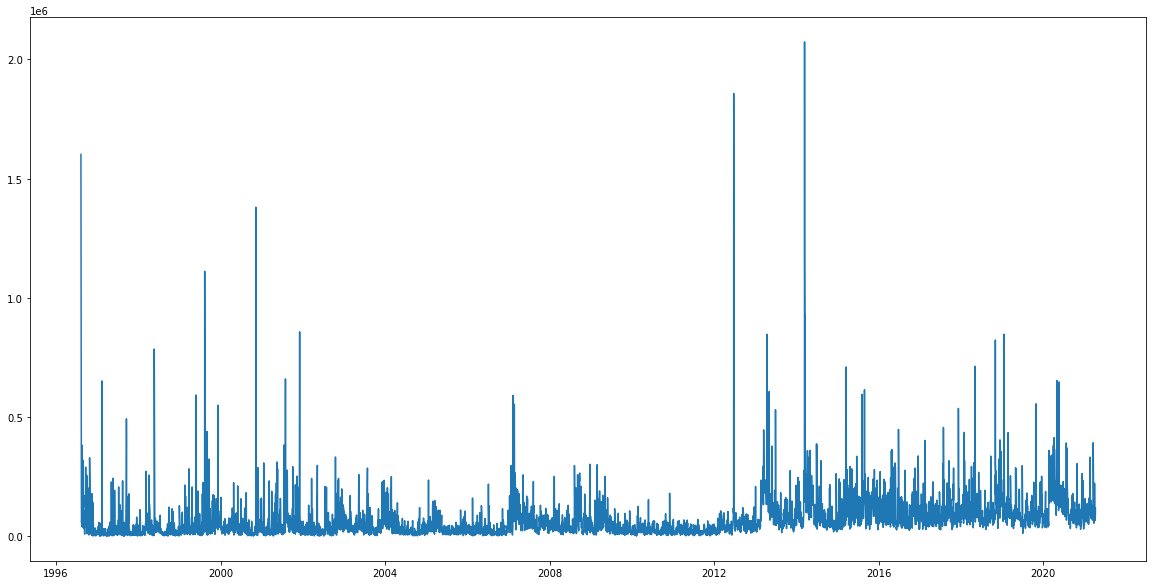

In [5]:
plt.figure(figsize=(20, 10))
plt.plot(data['Volume'])

In [6]:
def plot_error(train_loss,val_loss):
    plt.plot(train_loss,c = 'r')
    plt.plot(val_loss,c = 'b')
    plt.ylabel('Loss')
    plt.legend(['train','val'],loc = 'upper right')
    plt.show()

In [7]:
def plot_data(Y_test,Y_hat):
    plt.plot(Y_test,c = 'r')
    plt.plot(Y_hat,c = 'y')
    plt.xlabel('Day')
    plt.ylabel('Price')
    plt.title('Stock Prediction Graph using Multivariate-LSTM model')
    plt.legend(['Actual','Predicted'],loc = 'lower right')
    plt.show()

## data split

In [16]:
data = data[['Close', 'Open', 'High', 'Low', 'Volume']]
print(data)
train_start = dt.date(1996,8,9)
train_end = dt.date(2011,12,31)
train_data = data.loc[train_start:train_end]

val_start = dt.date(2012,1,1)
val_end = dt.date(2016,12,31)
val_data = data.loc[val_start:val_end]

test_start = dt.date(2016,1,1)
test_end = dt.date(2020,4,7)
test_data = data.loc[test_start:test_end]

print(train_data.shape,val_data.shape,test_data.shape)

                Close       Open       High        Low   Volume
Date                                                           
1996-08-09  16.500000  14.250000  16.750000  14.250000  1601500
1996-08-12  16.500000  16.500000  16.750000  16.375000   260900
1996-08-13  16.375000  16.500000  16.750000  16.375000   162800
1996-08-14  16.375000  16.375000  16.625000  16.375000    59500
1996-08-15  16.625000  16.625000  16.625000  16.375000    62300
...               ...        ...        ...        ...      ...
2021-04-01  36.139999  35.270000  36.340000  35.099998   111400
2021-04-05  36.529999  36.580002  36.849998  36.200001   114000
2021-04-06  36.660000  36.650002  36.930000  36.349998    66100
2021-04-07  35.759998  36.549999  36.680000  35.570000    83300
2021-04-08  35.320000  35.750000  35.790001  34.910000   116200

[6207 rows x 5 columns]
(3876, 5) (1258, 5) (1073, 5)


## Scaling

In [17]:
sc = StandardScaler()
train = sc.fit_transform(train_data)
val = sc.fit_transform(val_data)
test = sc.fit_transform(test_data)

## torch dataset

In [19]:
def convert2torch(data, time_step):
    X_data, y_data = list(), list()
    for i in range(time_step, len(data)):
        X_data.append(data[i-time_step:i])
        y_data.append(data[i][0])
    X_data, y_data = torch.Tensor(X_data), torch.Tensor(y_data)
    return X_data, y_data

In [20]:
batch_size = 128

X_train, y_train = convert2torch(train, 50)
train_data = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_data, shuffle=False, batch_size=batch_size)

X_val, y_val = convert2torch(val, 50)
val_data = TensorDataset(X_val, y_val)
val_loader = DataLoader(val_data, shuffle=False, batch_size=batch_size)

X_test, y_test = convert2torch(test, 50)
test_data = TensorDataset(X_test, y_test)
test_loader = DataLoader(test_data, shuffle=False, batch_size=1)

## Model

In [21]:
class MultivariateLSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super(MultivariateLSTM, self).__init__()
        self.input_dim = input_dim
        self.hidden_dim1 = hidden_dim[0]
        self.hidden_dim2 = hidden_dim[1]
        
        self.lstm1 = nn.LSTM(input_dim, input_dim, batch_first=True)
        self.lstm2 = nn.LSTM(input_dim, self.hidden_dim1, batch_first=True)
        self.lstm3 = nn.LSTM(self.hidden_dim1, self.hidden_dim2, batch_first=True)
        
        self.fc1 = nn.Linear(input_dim, 40)
        self.fc2 = nn.Linear(40, 35)
        self.fc3 = nn.Linear(35, 1)
        
    def forward(self, inp):
        h0, c0 = self.init_hidden(inp, self.input_dim)
        output, (h_t, c_t) = self.lstm1(inp, (h0, c0))
        h_t, c_t = self.fc1(h_t), self.fc1(c_t)
        output, (h_t, c_t) = self.lstm2(output, (h_t, c_t))
        h_t, c_t = self.fc2(h_t), self.fc2(c_t)
        output, (h_t, c_t) = self.lstm3(output, (h_t, c_t))
        output = self.fc3(h_t)
        return output
        
    def init_hidden(self, inp, c_size):
        b, seq_len, c = inp.size()
        h0 = torch.zeros(1, b, c_size)
        c0 = torch.zeros(1, b, c_size)
        return [t.cuda() for t in (h0, c0)]

In [22]:
with torch.no_grad():
    dataiter = iter(train_loader)
    X, y = dataiter.next()
    print(X.shape)
    print(y.shape)
    model = MultivariateLSTM(5, [40, 35]).cuda()
    output = model(X.cuda())
    print(output.shape)
    print(output)
    criterion = nn.MSELoss()
    loss = criterion(output.squeeze(), y.cuda())
    print(loss)

torch.Size([128, 50, 5])
torch.Size([128])
torch.Size([1, 128, 1])
tensor([[[-0.0333],
         [-0.0333],
         [-0.0332],
         [-0.0332],
         [-0.0332],
         [-0.0330],
         [-0.0326],
         [-0.0324],
         [-0.0322],
         [-0.0321],
         [-0.0322],
         [-0.0323],
         [-0.0324],
         [-0.0326],
         [-0.0328],
         [-0.0330],
         [-0.0331],
         [-0.0332],
         [-0.0332],
         [-0.0332],
         [-0.0332],
         [-0.0333],
         [-0.0334],
         [-0.0335],
         [-0.0335],
         [-0.0336],
         [-0.0336],
         [-0.0336],
         [-0.0337],
         [-0.0338],
         [-0.0338],
         [-0.0339],
         [-0.0340],
         [-0.0340],
         [-0.0341],
         [-0.0342],
         [-0.0342],
         [-0.0343],
         [-0.0343],
         [-0.0344],
         [-0.0344],
         [-0.0344],
         [-0.0344],
         [-0.0344],
         [-0.0344],
         [-0.0344],
         [-0.

## Train

In [23]:
class EarlyStopping:
    """Early stops the training if validation loss doesn't improve after a given patience."""
    def __init__(self, patience=7, verbose=False, delta=0, path='carr_ser_stackedLSTM.pth', trace_func=print):
        """
        Args:
            patience (int): How long to wait after last time validation loss improved.
                            Default: 7
            verbose (bool): If True, prints a message for each validation loss improvement. 
                            Default: False
            delta (float): Minimum change in the monitored quantity to qualify as an improvement.
                            Default: 0
            path (str): Path for the checkpoint to be saved to.
                            Default: 'checkpoint.pt'
            trace_func (function): trace print function.
                            Default: print            
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta
        self.path = path
        self.trace_func = trace_func
    def __call__(self, val_loss, model):

        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            self.trace_func(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        '''Saves model when validation loss decrease.'''
        if self.verbose:
            self.trace_func(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss

In [24]:
model = MultivariateLSTM(5, [40, 35]).cuda()

lr = 0.0001
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer=optimizer,
                                                       mode='min',
                                                       factor=0.2
                                                    )
criterion = nn.MSELoss().cuda()
patience = 20
n_epochs = 300

print(model)

MultivariateLSTM(
  (lstm1): LSTM(5, 5, batch_first=True)
  (lstm2): LSTM(5, 40, batch_first=True)
  (lstm3): LSTM(40, 35, batch_first=True)
  (fc1): Linear(in_features=5, out_features=40, bias=True)
  (fc2): Linear(in_features=40, out_features=35, bias=True)
  (fc3): Linear(in_features=35, out_features=1, bias=True)
)


In [25]:
def fit(model, batch_size, patience, n_epochs):
    
    train_losses = []
    valid_losses = []
    avg_train_losses = []
    avg_valid_losses = [] 
    
    early_stopping = EarlyStopping(patience=patience, verbose=True)
    
    for epoch in range(1, n_epochs + 1):

        ###################
        # train the model #
        ###################
        model.train()
        for data, target in train_loader:
            optimizer.zero_grad()
            data, target = data.cuda(), target.cuda()
            output = model(data)
            loss = criterion(output.squeeze(), target)
            loss.backward()
            optimizer.step()
            train_losses.append(loss.item())

        ######################    
        # validate the model #
        ######################
        model.eval()
        for data, target in val_loader:
            data, target = data.cuda(), target.cuda()
            output = model(data)
            loss = criterion(output.squeeze(), target)
            valid_losses.append(loss.item())

        train_loss = np.average(train_losses)
        valid_loss = np.average(valid_losses)
        avg_train_losses.append(train_loss)
        avg_valid_losses.append(valid_loss)
            
        epoch_len = len(str(n_epochs))
        
        print_msg = (f'[{epoch:>{epoch_len}}/{n_epochs:>{epoch_len}}] ' +
                     f'train_loss: {train_loss:.5f} ' +
                     f'valid_loss: {valid_loss:.5f}')
        
        print(print_msg)
        
        train_losses = []
        valid_losses = []
        early_stopping(valid_loss, model)
        
        if early_stopping.early_stop:
            print("Early stopping")
            break

    model.load_state_dict(torch.load('carr_ser_stackedLSTM.pth'))

    return  model, avg_train_losses, avg_valid_losses

In [26]:
def evaluate_model(model, test_loader):
    test_loss = 0.0
    y_test = []
    y_hat = []
    model.eval()
    for data, target in test_loader:
        data, target = data.cuda(), target.cuda()
        y_test.append(target)
        output = model(data)
        y_hat.append(output.view(1))
        loss = criterion(output.view(1), target)
        test_loss += loss.item()
    return test_loss/len(test_loader), y_test, y_hat

In [27]:
model, train_loss, valid_loss = fit(model, batch_size, patience, n_epochs)

[  1/300] train_loss: 0.98419 valid_loss: 0.95097
Validation loss decreased (inf --> 0.950969).  Saving model ...
[  2/300] train_loss: 0.97730 valid_loss: 0.94784
Validation loss decreased (0.950969 --> 0.947840).  Saving model ...
[  3/300] train_loss: 0.97388 valid_loss: 0.94447
Validation loss decreased (0.947840 --> 0.944474).  Saving model ...
[  4/300] train_loss: 0.97008 valid_loss: 0.94057
Validation loss decreased (0.944474 --> 0.940572).  Saving model ...
[  5/300] train_loss: 0.96548 valid_loss: 0.93583
Validation loss decreased (0.940572 --> 0.935828).  Saving model ...
[  6/300] train_loss: 0.95967 valid_loss: 0.92978
Validation loss decreased (0.935828 --> 0.929775).  Saving model ...
[  7/300] train_loss: 0.95202 valid_loss: 0.92162
Validation loss decreased (0.929775 --> 0.921621).  Saving model ...
[  8/300] train_loss: 0.94148 valid_loss: 0.90995
Validation loss decreased (0.921621 --> 0.909952).  Saving model ...
[  9/300] train_loss: 0.92623 valid_loss: 0.89214
Val

In [11]:
model.load_state_dict(torch.load('carr_ser_stackedLSTM.pth'))

<All keys matched successfully>

In [28]:
test_loss, y_test, y_hat = evaluate_model(model, test_loader)

In [31]:
test_loss

0.14020268761376617

In [29]:
target, predicted = list(), list()
for i in range(len(y_test)):
    target.append(y_test[i].item())
    predicted.append(y_hat[i][0].item())

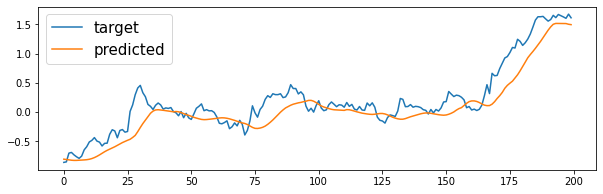

In [30]:
plt.figure(figsize=(10, 3))
plt.plot(target[:200], label='target')
plt.plot(predicted[:200], label='predicted')
plt.legend(loc='upper left', fontsize=15)
plt.show()

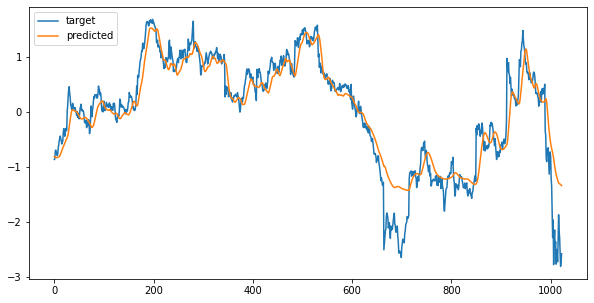

In [32]:
plt.figure(figsize=(10, 5))
plt.plot(target, label='target')
plt.plot(predicted, label='predicted')
plt.legend()
plt.show()